In [1]:
from sklearn import metrics
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split # split dataset 
from sklearn.metrics import mean_squared_error, r2_score # get error

from sklearn.ensemble import RandomForestRegressor # use random forest regressor
from sklearn.model_selection import GridSearchCV # use gridsearchCV for optimal parameters

from joblib import Memory # save machine learning model

import joblib as joblib
import numpy as np
import pandas as pd

# Load Data

In [2]:
train_data = pd.read_csv('../data/transformed/train_pipeline_data.csv') # create data

train_data = train_data.loc[train_data['hours_needed'] != 0] # remove 0 hours 
train_data = train_data.loc[train_data['hours_needed'] < 1440] # 1440hours = 60days

In [3]:
# split data into features and data to predict value
X = train_data.drop(columns = ['resolutiondate', 'Unnamed: 0', 'hours_needed', 'index']).to_numpy()
y = train_data[['hours_needed']].to_numpy()

# 70train - 30test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Random Forest Regression

In [4]:
randomforest = RandomForestRegressor() # initialize algorithm

# set parameters to search
param_grid = {
    'bootstrap': [True],
    'max_depth': [180, 200, 220],
    'max_features': [15, 20, 30],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 5, 10, 12, 14, 16],
    'n_estimators': [10, 50, 100]
}

grid_search = GridSearchCV(estimator = randomforest, 
                           param_grid = param_grid, 
                           cv = 4,
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 648 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:   56.5s finished
/Users/thomsuykerbuyk/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [5]:
randomforest_best = RandomForestRegressor(**grid_search.best_params_) # use best parameters
randomforest_best.fit(X_train, y_train) # fit data on best parameters

/Users/thomsuykerbuyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=220,
                      max_features=15, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=14,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# Visualize prediction

/Users/thomsuykerbuyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


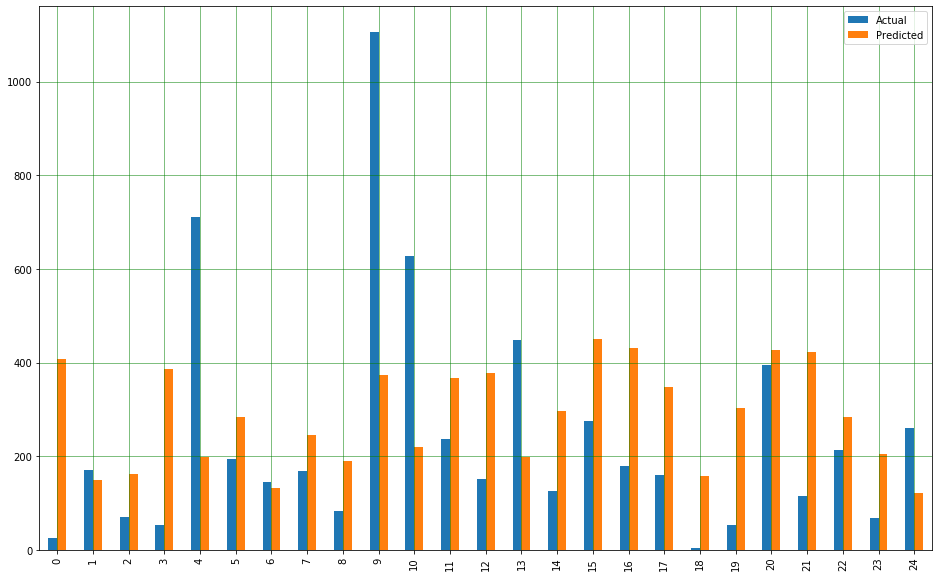

In [6]:
y_pred = randomforest_best.predict(X_test) # show prediction

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}) # save prediction in df
df1 = df.head(25)
df1['Predicted'] = [int(i) for i in df1['Predicted']]
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [7]:
# Show errorr
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred) / 24) # /24 to get # of days
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ 24)

Mean Absolute Error: 8.662829800706712
Mean Squared Error: 75646.90906320297
Root Mean Squared Error: 11.459992990653987


## Save Feature Importance

In [8]:
#split data into features and ot predict value
X = train_data.drop(columns = ['resolutiondate', 'Unnamed: 0', 'hours_needed', 'index'])
y = train_data[['hours_needed']]

# 70train - 30test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


test = randomforest_best.fit(X_train, y_train)
feature_importances = pd.DataFrame(test.feature_importances_,
                                   index = X_train.columns,
                                   columns = ['importance']).sort_values('importance', ascending=False)

feature_importances.to_csv("../data/feature_importance/feature_importance.csv")

/Users/thomsuykerbuyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


# Save model

In [10]:
# save machine learning model that has been created
filename = '../model/machine_learning_model.sav'
joblib.dump(randomforest_best, filename)

['../model/machine_learning_model.sav']